In [55]:
from tqdm import tqdm
import pandas as pd
import folium
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
nbins=10
built_percent_column = 'Built_2020_10km_percent'  # Variable for Built percentage column

# Function to read station inventory
def read_station_inventory(station_file_path):
    colspecs = [
        (0, 11),    # Station ID
        (12, 20),   # Latitude
        (21, 30),   # Longitude
        (31, 37),   # Elevation
        (38, None)  # Station Name
    ]
    columns = ['station_id', 'latitude', 'longitude', 'elevation', 'name']
    stations = pd.read_fwf(station_file_path, colspecs=colspecs, header=None, names=columns)
    stations['station_id'] = stations['station_id'].str.strip()
    stations['name'] = stations['name'].str.strip()
    stations['latitude'] = pd.to_numeric(stations['latitude'], errors='coerce')
    stations['longitude'] = pd.to_numeric(stations['longitude'], errors='coerce')
    stations['elevation'] = pd.to_numeric(stations['elevation'], errors='coerce')
    stations['country_code'] = stations['station_id'].str[:2]
    return stations

# Function to analyze station data with a progress bar
def analyze_station_data(file_path, station_file_path, start_year, end_year, lat_min=None, lat_max=None, country_codes=None, max_pct_missing=0):
    """
    Analyze station data with optional filters for latitude and country codes.

    Parameters:
    file_path (str): Path to the GHCN data file.
    station_file_path (str): Path to the station inventory file.
    start_year (int): Start year for filtering.
    end_year (int): End year for filtering.
    lat_max (float, optional): Maximum latitude for filtering. Defaults to None.
    lat_min (float, optional): Mainimum latitude for filtering. Defaults to None.
    country_codes (list, optional): List of country codes for filtering. Defaults to None.
    max_pct_missing (float, optional): Maximum percentage of missing months allowed for a station. Defaults to 0.

    Returns:
    pd.DataFrame: Filtered and processed station data.
    """

    # Read the station inventory
    stations = read_station_inventory(station_file_path)
    
    # Apply latitude filters if provided
    if lat_min is not None:
        stations = stations[stations['latitude'] >= lat_min]
        print(f"Filter applied: Latitude >= {lat_min}")
        print(f"Number of stations after minimum latitude filter: {len(stations)}")
    if lat_max is not None:
        stations = stations[stations['latitude'] <= lat_max]
        print(f"Filter applied: Latitude <= {lat_max}")
        print(f"Number of stations after latitude filter: {len(stations)}")
    
    # Apply country code filter if provided
    if country_codes is not None:
        stations = stations[stations['country_code'].isin(country_codes)]
        print(f"Filter applied: Country codes in {country_codes}")
        print(f"Number of stations after country code filter: {len(stations)}")
    
    station_ids = stations['station_id'].tolist()

    # Define the fixed-width columns for the data as per GHCN format
    colspecs = [(0, 11), (11, 15), (15, 19)]
    for i in range(12):
        start = 19 + i * 8
        colspecs.extend([
            (start, start + 5),    # Value
            (start + 5, start + 6),  # MFlag
            (start + 6, start + 7),  # QFlag
            (start + 7, start + 8)   # SFlag
        ])

    # Read the GHCN data in chunks
    chunk_size = 100000
    total_lines = sum(1 for line in open(file_path))  # Estimate total lines for progress tracking
    data_chunks = pd.read_fwf(file_path, colspecs=colspecs, chunksize=chunk_size, header=None)

    columns = ['station_id', 'year', 'element']
    for i in range(1, 13):
        columns.extend([f'value_{i}', f'mflag_{i}', f'qflag_{i}', f'sflag_{i}'])

    data_list = []
    print("Processing file in chunks with progress tracking...")
    for chunk in tqdm(data_chunks, total=total_lines // chunk_size + 1):  # Adding progress bar
        chunk.columns = columns
        chunk = chunk[chunk['element'] == 'TAVG']
        chunk = chunk[chunk['station_id'].isin(station_ids)]  # Filter by station IDs from station inventory
        
        # Replace missing data values (-9999) with NaN
        value_cols = [f'value_{i}' for i in range(1, 13)]
        chunk[value_cols] = chunk[value_cols].replace(-9999, pd.NA)
        
        # Filter by year range
        chunk = chunk[(chunk['year'] >= start_year) & (chunk['year'] <= end_year)]
        
        # Melt the data to long format
        melted_data = chunk.melt(id_vars=['station_id', 'year'], value_vars=value_cols, var_name='month', value_name='tavg')
        melted_data['month'] = melted_data['month'].str.extract('value_(\d+)').astype(int)
        
        # Append the processed chunk to the data list
        data_list.append(melted_data)

    # Concatenate all the processed chunks into a single DataFrame
    filtered_data = pd.concat(data_list, ignore_index=True)
    
    # Drop rows with missing temperature values
    filtered_data = filtered_data.dropna(subset=['tavg'])
    
    # Calculate the percentage of missing months for each station
    total_months = (end_year - start_year + 1) * 12
    station_missing = filtered_data.groupby('station_id').size().reset_index(name='observed_months')
    station_missing['pct_missing'] = 1 - station_missing['observed_months'] / total_months
    
    # Filter out stations with more than the allowed percentage of missing months
    valid_stations = station_missing[station_missing['pct_missing'] <= max_pct_missing]['station_id']
    filtered_data = filtered_data[filtered_data['station_id'].isin(valid_stations)]
    print(f"Number of stations with less than {max_pct_missing * 100}% missing data: {len(valid_stations)}")

    # Merge with station information
    filtered_data = filtered_data.merge(stations[['station_id', 'latitude', 'longitude', 'elevation', 'name', 'country_code']], on='station_id', how='left')

    return filtered_data


# Function to calculate baseline and anomalies with configurable baseline period
def calculate_baseline_and_anomaly(data, baseline_start=1920, baseline_end=1940):
    data['tavg'] = data['tavg'] / 100
    print(f"Calculating baseline ({baseline_start}-{baseline_end}) and anomalies...")
    baseline_data = data[(data['year'] >= baseline_start) & (data['year'] <= baseline_end)]
    baseline = baseline_data.groupby(['station_id', 'month'])['tavg'].mean().reset_index()
    baseline.rename(columns={'tavg': 'baseline'}, inplace=True)
    data_with_baseline = pd.merge(data, baseline, on=['station_id', 'month'], how='left')
    data_with_baseline['anomaly'] = data_with_baseline['tavg'] - data_with_baseline['baseline']
    data_with_baseline = data_with_baseline.dropna(subset=['baseline'])
    return data_with_baseline


# Read and filter metadata file
metadata_file = r'C:\Users\Administrator\GHCN_stations_with_Landsat_GHSL_BU_1975to2020_metadata.csv'
metadata_df = pd.read_csv(metadata_file)

def merge_and_filter_metadata(filtered_data, metadata_df):
    # Filter metadata based on station IDs in filtered_data
    filtered_metadata = metadata_df[metadata_df['ID'].isin(filtered_data['station_id'])]
    
    # Create urbanization bins based on the specified built percentage column after filtering
    bins = pd.qcut(filtered_metadata[built_percent_column], nbins, labels=False, retbins=True)
    filtered_metadata['urbanization_bin'] = bins[0]
    bin_ranges = bins[1]
    
    # Merge filtered data with metadata
    merged_data = pd.merge(filtered_data, filtered_metadata[['ID', 'urbanization_bin', built_percent_column]], 
                           left_on='station_id', right_on='ID', how='left')
    
    # Save filtered stations to CSV without duplicates
    merged_data[['station_id', 'urbanization_bin']].drop_duplicates(subset='station_id').to_csv('filtered_stations.csv', index=False)       

    return merged_data, bin_ranges

# Function to plot LOESS smoothed anomaly data by urbanization bins with ranges in the labels
def plot_loess_by_urbanization_bins(merged_data, bin_ranges):
    print("Plotting LOESS smoothed temperature anomalies for urbanization bins...")

    plt.figure(figsize=(12, 8))
    
    # Loop through each urbanization bin and plot LOESS smoothed anomaly
    for bin_number in sorted(merged_data['urbanization_bin'].unique()):
        bin_data = merged_data[merged_data['urbanization_bin'] == bin_number]

        # Aggregate yearly anomalies
        yearly_anomalies = bin_data.groupby('year')['anomaly'].mean().reset_index()

        # Apply LOESS smoothing
        loess_smoothed = lowess(yearly_anomalies['anomaly'], yearly_anomalies['year'], frac=0.1)

        # Plot LOESS line for this urbanization bin
        plt.plot(loess_smoothed[:, 0], loess_smoothed[:, 1], label=f'BU {bin_ranges[bin_number]:.2f}-{bin_ranges[bin_number + 1]:.2f}', linewidth=2)

    # Plot formatting
    plt.title('LOESS Smoothed Temperature Anomalies by Urbanization Bin (1920-2020)')
    plt.xlabel('Year')
    plt.ylabel('Anomaly (°C)')
    plt.legend(title=f'Urbanization Bins ({built_percent_column}, 10km)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Define the file paths
file_path = r'C:\Users\Administrator\Downloads\ghcn\ghcnm.tavg.latest.qcu\ghcnm.v4.0.1.20240616\ghcnm.tavg.v4.0.1.20240616.qcu.dat'
station_file_path = r'C:\Users\Administrator\Downloads\ghcn\ghcnm.tavg.latest.qcu\ghcnm.v4.0.1.20240616\ghcnm.tavg.v4.0.1.20240616.qcu.inv'
# Set baseline period for anomalies
baseline_start = 1920
baseline_end = 1940
ys = 1910
ye = 2023

# Run analysis and plot, filters are optional: comment out to deactivate
filtered_data = analyze_station_data(
    file_path, 
    station_file_path, 
    start_year=ys, 
    end_year=ye, 
    lat_min=20,
    lat_max=60, 
    #country_codes=["US"],
    max_pct_missing=0.1 #allow some missing months to avoid to strict station exclusion filter
)

anomaly_data = calculate_baseline_and_anomaly(filtered_data, baseline_start, baseline_end)


Filter applied: Latitude >= 20
Number of stations after minimum latitude filter: 23644
Filter applied: Latitude <= 60
Number of stations after latitude filter: 21793
Processing file in chunks with progress tracking...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:48<00:00,  7.21s/it]


Number of stations with less than 10.0% missing data: 1462
Calculating baseline (1920-1940) and anomalies...


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_1040\330879394.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metadata['urbanization_bin'] = bins[0]


Plotting LOESS smoothed temperature anomalies for urbanization bins...


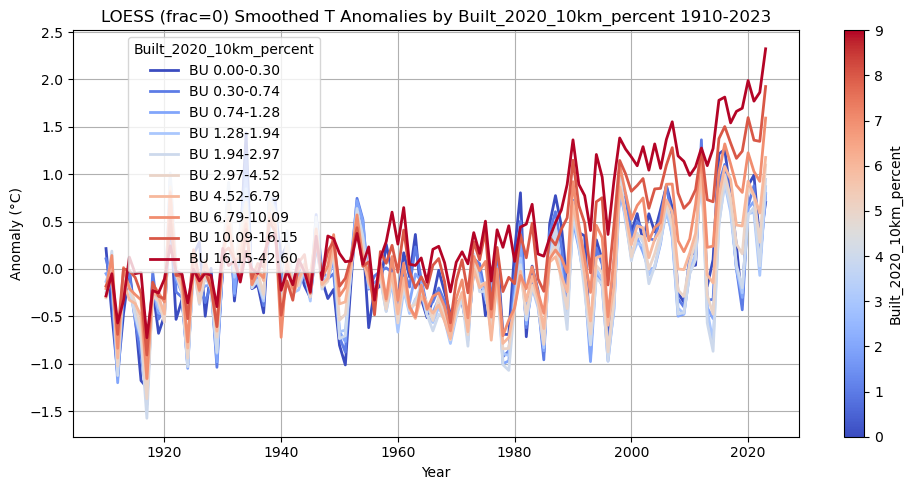

Plotting LOESS smoothed temperature anomalies as climate stripes for urbanization bins...


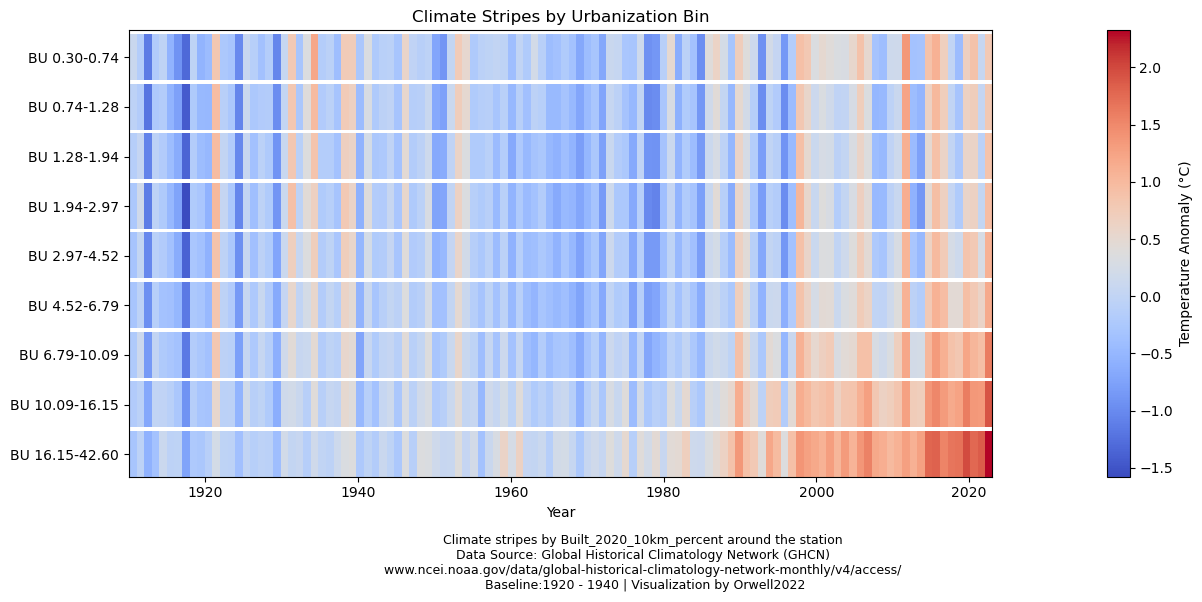

In [62]:
# Function to plot LOESS smoothed anomaly data by urbanization bins with color coding
import matplotlib.colors as mcolors
import numpy as np
frac=0

def plot_loess_by_urbanization_bins(merged_data, bin_ranges):
    print("Plotting LOESS smoothed temperature anomalies for urbanization bins...")

    # Create a color map from blue to red for 10 bins
    cmap = plt.get_cmap('coolwarm')
    norm = mcolors.Normalize(vmin=0, vmax=nbins-1)  # Normalize to the range of bin numbers

    fig, ax = plt.subplots(figsize=(10, 5))  # Explicitly define figure and axis

    # Loop through each urbanization bin and plot LOESS smoothed anomaly with corresponding color
    for bin_number in sorted(merged_data['urbanization_bin'].dropna().unique().astype(int)):
        bin_data = merged_data[merged_data['urbanization_bin'] == bin_number]

        # Aggregate yearly anomalies
        yearly_anomalies = bin_data.groupby('year')['anomaly'].mean().reset_index()

        # Apply LOESS smoothing
        loess_smoothed = lowess(yearly_anomalies['anomaly'], yearly_anomalies['year'], frac)

        # Plot LOESS line for this urbanization bin with color based on bin_number
        color = cmap(norm(bin_number))
        ax.plot(loess_smoothed[:, 0], loess_smoothed[:, 1], label=f'BU {bin_ranges[bin_number]:.2f}-{bin_ranges[bin_number + 1]:.2f}', color=color, linewidth=2)

    # Plot formatting
    ax.set_title('LOESS (frac='+str(frac)+') Smoothed T Anomalies by ' + built_percent_column + " " +str(ys)+"-"+str(ye))
    ax.set_xlabel('Year')
    ax.set_ylabel('Anomaly (°C)')

    # Move the legend outside the plot area
    ax.legend(title=built_percent_column, bbox_to_anchor=(0.35, 1), loc='upper right')

    # Add a color bar to represent the urbanization bin colors
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Only need to set array if using a color bar
    fig.colorbar(sm, ax=ax, label=built_percent_column)

    ax.grid(True)
    plt.tight_layout()
    plt.show()

# Example of how to run the updated functions
merged_data, bin_ranges = merge_and_filter_metadata(anomaly_data, metadata_df)
plot_loess_by_urbanization_bins(merged_data, bin_ranges)


# Function to plot LOESS smoothed anomaly data as climate stripes by urbanization bins with white space and footer
def plot_stripes_by_urbanization_bins(merged_data, bin_ranges, footer_text):
    print("Plotting LOESS smoothed temperature anomalies as climate stripes for urbanization bins...")

    # Create a color map from blue to red
    cmap = plt.get_cmap('coolwarm')

    # Prepare the figure with a taller aspect ratio to accommodate all bins
    unique_bins = sorted(merged_data['urbanization_bin'].dropna().unique().astype(int))
    unique_bins = unique_bins[1:]  # Remove the first bin from plotting
    num_bins = len(unique_bins)

    fig, ax = plt.subplots(figsize=(13, num_bins * 0.6))  # Adjust the height to better fit the stripes

    # Initialize an empty list to hold all the stripe colors
    all_stripes = []

    # Calculate overall min and max anomalies across all bins for consistent color scaling
    overall_min = float('inf')
    overall_max = float('-inf')

    for bin_number in unique_bins:
        bin_data = merged_data[merged_data['urbanization_bin'] == bin_number]

        # Aggregate yearly anomalies
        yearly_anomalies = bin_data.groupby('year')['anomaly'].mean().reset_index()

        # Apply LOESS smoothing
        loess_smoothed = lowess(yearly_anomalies['anomaly'], yearly_anomalies['year'], frac)

        # Update the overall min/max based on the LOESS smoothed anomalies
        overall_min = min(overall_min, np.min(loess_smoothed[:, 1]))
        overall_max = max(overall_max, np.max(loess_smoothed[:, 1]))

        # Append smoothed values to the stripe list
        all_stripes.append(loess_smoothed[:, 1])

    # Reverse the order of stripes and bin ranges for plotting (low BU on top)
    all_stripes = all_stripes[::-1]
    reversed_bins = unique_bins[::-1]

    # Normalize the LOESS-smoothed anomalies for consistent coloring across all bins
    norm = plt.Normalize(vmin=overall_min, vmax=overall_max)

    # Plot each stripe with white space between
    stripe_height = 1  # Height of each stripe
    gap = 0.1  # White space between each stripe
    for i, stripe_data in enumerate(all_stripes):
        # Normalize the stripe data to fit the color map
        stripe_colors = cmap(norm(stripe_data))
        # Plot the stripe with a gap between the next stripe
        y_start = i * (stripe_height + gap)
        y_end = y_start + stripe_height
        ax.imshow([stripe_colors], aspect='auto', extent=[ys, ye, y_start, y_end])

    # Adjust the y-axis limits to make sure all stripes fit evenly, including the last stripe
    ax.set_ylim(0, num_bins * (stripe_height + gap))

    # Set labels and title
    ax.set_title('Climate Stripes by Urbanization Bin')
    ax.set_xlabel('Year')
    ax.set_yticks(np.arange(len(reversed_bins)) * (stripe_height + gap) + 0.5 * stripe_height)  # Center the tick labels
    ax.set_yticklabels([f'BU {bin_ranges[bin_number]:.2f}-{bin_ranges[bin_number + 1]:.2f}' for bin_number in reversed_bins])

    # Add the color bar at the right of the plot
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Only needed for the color bar
    fig.colorbar(sm, ax=ax, orientation='vertical', label='Temperature Anomaly (°C)', pad=0.1)

    # Add the footer text at the bottom of the figure
    fig.text(
        0.5, -0.1,
        footer_text,
        ha='center', fontsize=9
    )

    plt.tight_layout()
    plt.show()

# Example footer text
footer_text = (
    "Climate stripes by "+built_percent_column+" around the station \n"
    "Data Source: Global Historical Climatology Network (GHCN) \n"
    "www.ncei.noaa.gov/data/global-historical-climatology-network-monthly/v4/access/ \n"
    "Baseline:" +str(baseline_start)+" - "+str(baseline_end)+" | "
    "Visualization by Orwell2022"
)

# Example of how to run the updated function
plot_stripes_by_urbanization_bins(merged_data, bin_ranges, footer_text)

Plotting stations on a world map by urbanization bin...


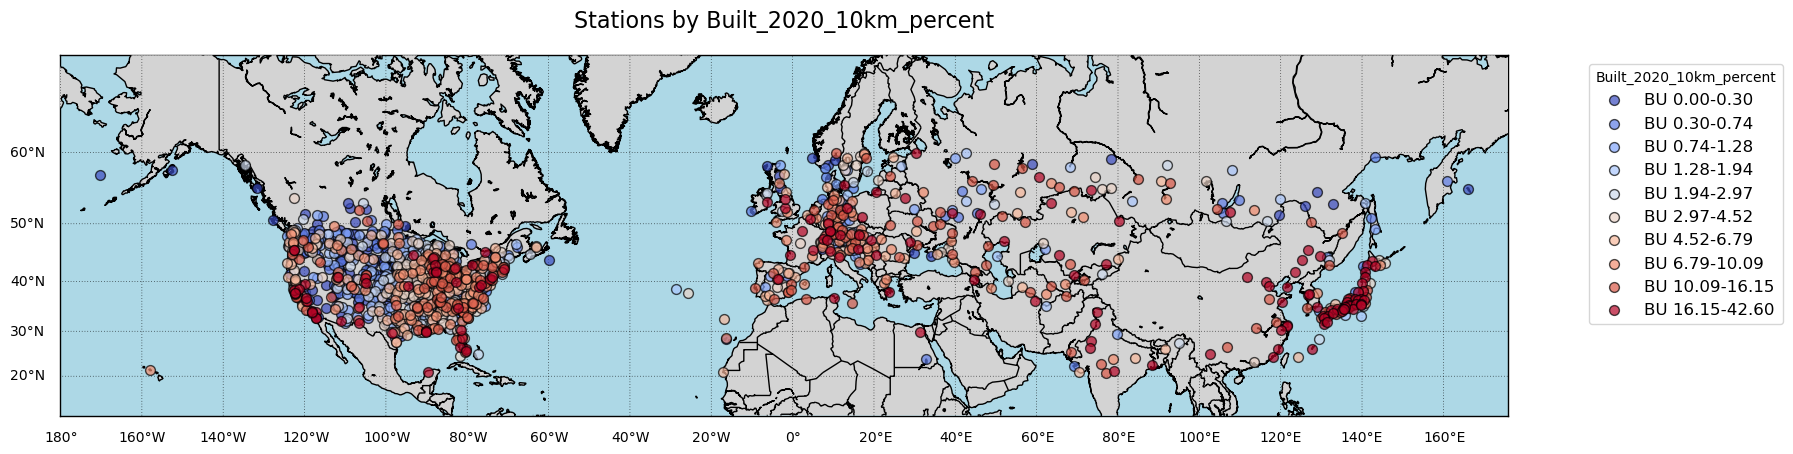

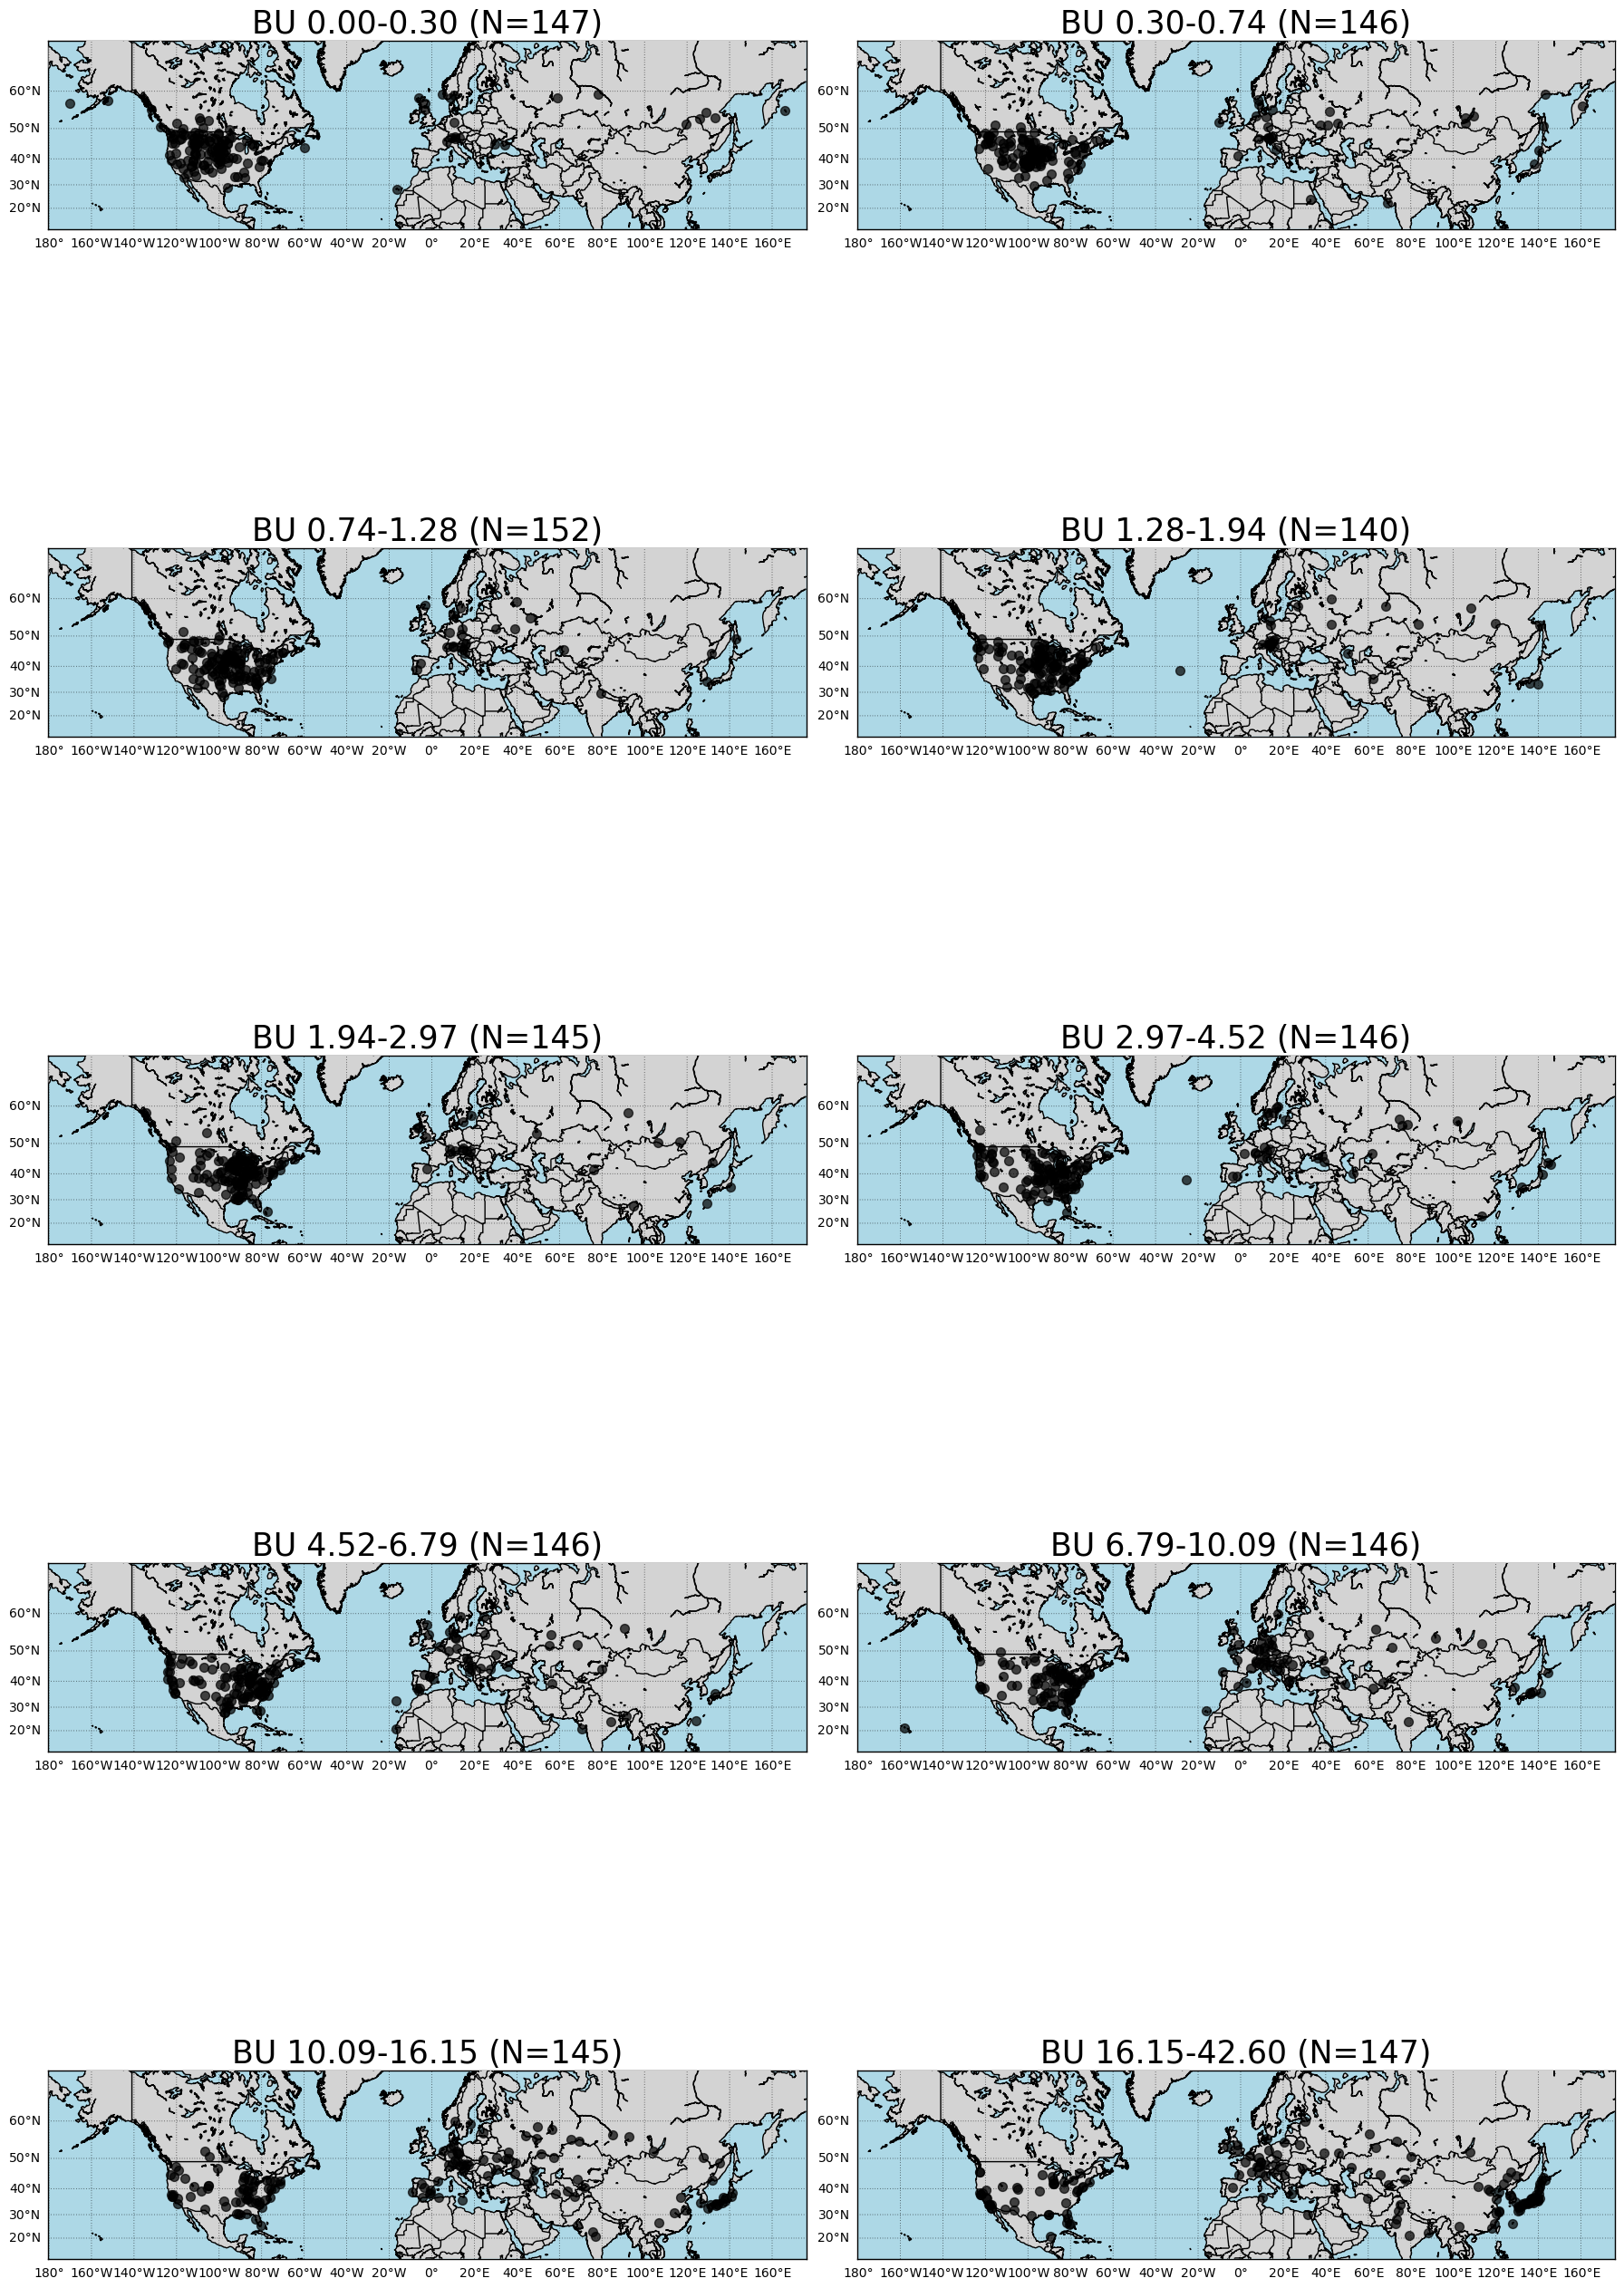

In [57]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.basemap import Basemap
import numpy as np

# Function to plot stations on a world map using Basemap
def plot_station_maps_with_bins(merged_data, bin_ranges):
    print("Plotting stations on a world map by urbanization bin...")

    # Create a color map from blue to red for urbanization bins
    cmap = plt.get_cmap('coolwarm')
    norm = mcolors.Normalize(vmin=0, vmax=len(bin_ranges) - 2)

    # Master plot with all bins
    plt.figure(figsize=(18, 12))
    min_lon, max_lon = merged_data['longitude'].min() - 10, merged_data['longitude'].max() + 10
    min_lat, max_lat = max(-80, merged_data['latitude'].min() - 10), min(80, merged_data['latitude'].max() + 10)
    m = Basemap(projection='merc', llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='l')
    m.drawmapboundary(fill_color='lightblue', zorder=1)
    m.fillcontinents(color='lightgray', lake_color='lightblue', zorder=2)
    m.drawcoastlines(linewidth=1.0, zorder=3)
    m.drawcountries(linewidth=1.0, zorder=3)
    m.drawparallels(np.arange(-80., 81., 10.), labels=[1, 0, 0, 0], linewidth=0.5, dashes=[1, 3], fontsize=10, zorder=4)
    m.drawmeridians(np.arange(-180., 181., 20.), labels=[0, 0, 0, 1], linewidth=0.5, dashes=[1, 3], fontsize=10, zorder=4)

    # Plot stations by urbanization bin using a color map
    for bin_number in sorted(merged_data['urbanization_bin'].dropna().unique().astype(int)):
        bin_data = merged_data[merged_data['urbanization_bin'] == bin_number].drop_duplicates(subset=['longitude', 'latitude']).dropna(subset=['longitude', 'latitude'])
        if bin_data.empty:
            continue
        color = cmap(norm(bin_number))
        lon = bin_data['longitude'].values
        lat = bin_data['latitude'].values
        x, y = m(lon, lat)
        m.scatter(x, y, marker='o', color=color, s=50, edgecolor='k', alpha=0.7, zorder=5, label=f'BU {bin_ranges[bin_number]:.2f}-{bin_ranges[bin_number + 1]:.2f}')

    # Remove duplicate labels in the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    if handles:
        by_label = dict(zip(labels, handles))
        plt.legend(title='Urbanization Bins (BU 2020, 10km)', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    by_label = dict(zip(labels, handles))
    plt.legend(handles=by_label.values(), labels=by_label.keys(), title=built_percent_column, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

    # Title and formatting
    plt.title("Stations by "+built_percent_column, fontsize=16, pad=20)

    # Save the master plot as an image
    plt.tight_layout()
    plt.savefig('station_map_urbanization_bins_master.png')
    plt.show()

    # Create subplots for each bin
    fig, axes = plt.subplots(5, 2, figsize=(18, 30))
    axes = axes.flatten()

    # Plot each bin in a separate subplot
    for idx, bin_number in enumerate(sorted(merged_data['urbanization_bin'].dropna().unique().astype(int))):
        ax = axes[idx]
        plt.sca(ax)

        # Set up the Basemap
        m = Basemap(projection='merc', llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='l', ax=ax)
        m.drawmapboundary(fill_color='lightblue', zorder=1)
        m.fillcontinents(color='lightgray', lake_color='lightblue', zorder=2)
        m.drawcoastlines(linewidth=1.0, zorder=3)
        m.drawcountries(linewidth=1.0, zorder=3)
        m.drawparallels(np.arange(-90., 91., 10.), labels=[1, 0, 0, 0], linewidth=0.5, dashes=[1, 3], fontsize=10, zorder=4)
        m.drawmeridians(np.arange(-180., 181., 20.), labels=[0, 0, 0, 1], linewidth=0.5, dashes=[1, 3], fontsize=10, zorder=4)

        # Plot stations in the current urbanization bin
        bin_data = merged_data[merged_data['urbanization_bin'] == bin_number].drop_duplicates(subset=['longitude', 'latitude']).dropna(subset=['longitude', 'latitude'])
        color = cmap(norm(bin_number))
        lon = bin_data['longitude'].values
        lat = bin_data['latitude'].values
        x, y = m(lon, lat)
        m.scatter(x, y, marker='o', color='black', s=50, edgecolor='k', alpha=0.7, zorder=5)

        # Title for each subplot with the number of points
        ax.set_title(f'BU {bin_ranges[bin_number]:.2f}-{bin_ranges[bin_number + 1]:.2f} (N={len(lon)})', fontsize=25)

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig('station_maps_urbanization_bins_subplot.png')
    plt.show()

# Example of how to run the updated mapping function
plot_station_maps_with_bins(merged_data, bin_ranges)

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_1040\1428929965.py:150: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp_pivot = temp_pivot.replace({pd.NA: np.nan}).astype(float)


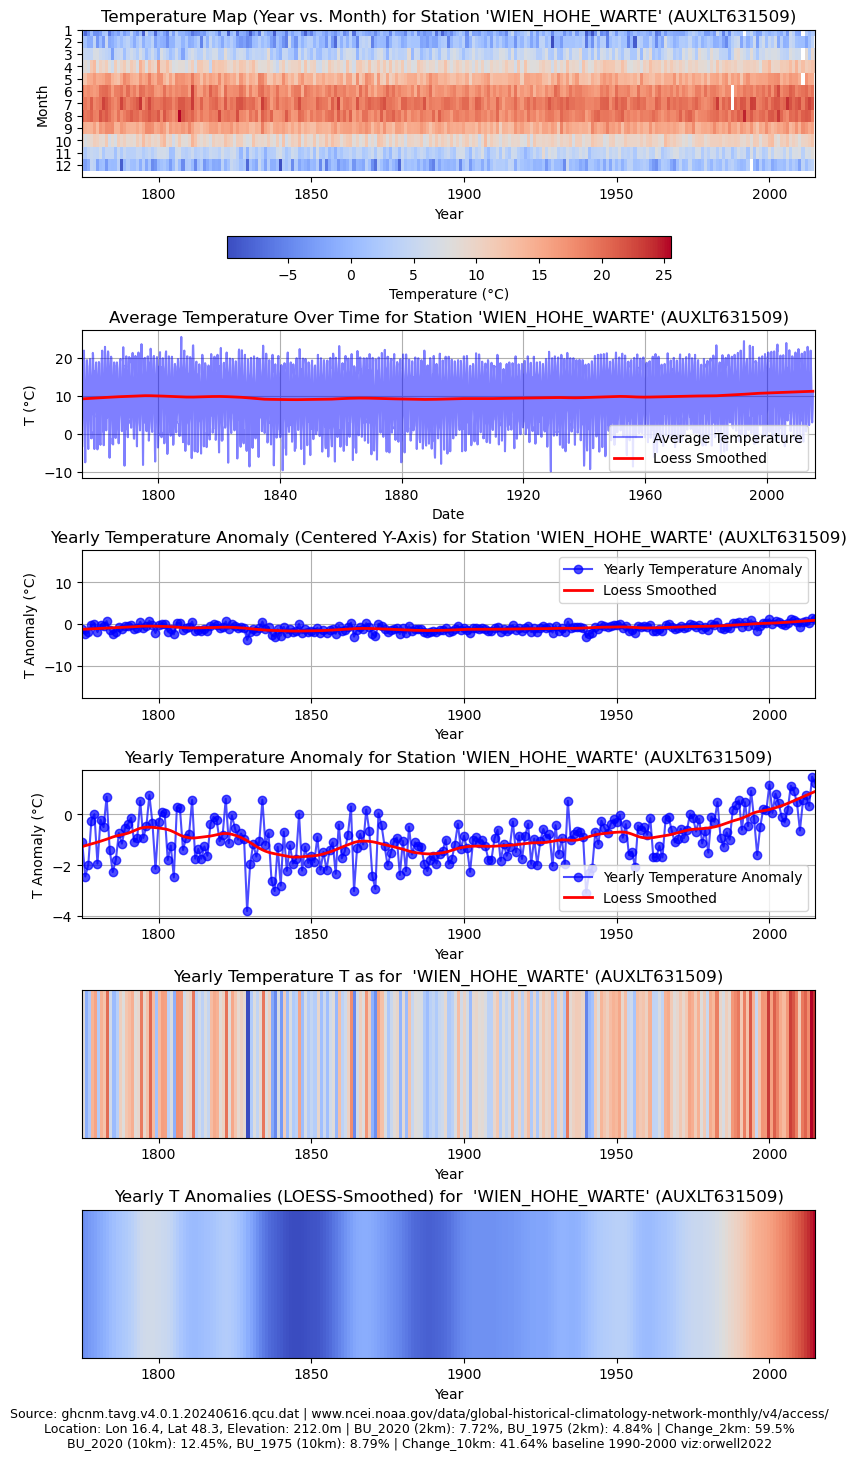

In [58]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm  # For LOESS smoothing
import matplotlib.dates as mdates  # For date conversions
import io
import os  # To extract the file name from the path


# Define the file paths
metadata_file = r'C:\Users\Administrator\GHCN_stations_with_Landsat_GHSL_BU_1975to2020_metadata.csv'
ghcn_data_file = r'C:\Users\Administrator\Downloads\ghcn\ghcnm.tavg.latest.qcu\ghcnm.v4.0.1.20240616\ghcnm.tavg.v4.0.1.20240616.qcu.dat'

# Extract the file name from the ghcn_data_file path
data_file_name = os.path.basename(ghcn_data_file)

# Step 1: Read the Metadata File and Get Station ID with Exact Matching
def get_station_id(metadata_file, station_name):
    # Read the metadata file
    metadata_df = pd.read_csv(metadata_file)
    # Rename columns to standardize
    metadata_df = metadata_df.rename(columns={
        'ID': 'station_id',
        'Station': 'name',
        'Lat': 'latitude',
        'Lon': 'longitude',
        'Elev-m': 'elevation'
    })
    # Ensure station names are strings
    metadata_df['name'] = metadata_df['name'].astype(str)
    # Find the station ID for the given station name using exact match
    matching_stations = metadata_df[metadata_df['name'].str.upper() == station_name.upper()]
    if matching_stations.empty:
        print(f"No station found with name exactly matching '{station_name}'")
        return None, None
    else:
        # Select the first matching station (there should only be one)
        station_id = matching_stations['station_id'].iloc[0]
        station_name_full = matching_stations['name'].iloc[0]
        return station_id, station_name_full

# Step 2: Read Only the Data for the Specific Station from the GHCN Data File
def read_station_data(ghcn_data_file, station_id):
    # Prepare to read the fixed-width formatted data
    colspecs = [(0, 11), (11, 15), (15, 19)]
    for i in range(12):
        start = 19 + i * 8
        colspecs.extend([
            (start, start + 5),     # Value
            (start + 5, start + 6), # MFlag
            (start + 6, start + 7), # QFlag
            (start + 7, start + 8)  # SFlag
        ])
    columns = ['station_id', 'year', 'element']
    for i in range(1, 13):
        columns.extend([f'value_{i}', f'mflag_{i}', f'qflag_{i}', f'sflag_{i}'])

    # Initialize an empty list to store data
    data_list = []

    # Open the data file
    try:
        with open(ghcn_data_file, 'r') as file:
            for line in file:
                # Check if the line corresponds to the desired station_id and element 'TAVG'
                if line[0:11].strip() == station_id and line[15:19].strip() == 'TAVG':
                    # Read the line using pandas.read_fwf
                    df_line = pd.read_fwf(io.StringIO(line), colspecs=colspecs, header=None)
                    df_line.columns = columns
                    data_list.append(df_line)
    except FileNotFoundError:
        print(f"File not found: {ghcn_data_file}")
        return None

    if not data_list:
        print(f"No data found for station '{station_id}' in the GHCN data file.")
        return None

    # Concatenate all the data into a single DataFrame
    station_data = pd.concat(data_list, ignore_index=True)
    return station_data

# Step 3: Process and Plot the Data
def process_and_plot_station_data(station_data, station_id, station_name_full, data_file_name):
    # Replace -9999 with NaN and convert temperature to degrees Celsius
    value_cols = [f'value_{i}' for i in range(1, 13)]
    station_data[value_cols] = station_data[value_cols].replace(-9999, pd.NA)
    station_data[value_cols] = station_data[value_cols] / 100.0  # Convert to degrees Celsius

    # Melt the data to have one row per observation
    station_data_long = station_data.melt(
        id_vars=['station_id', 'year'],
        value_vars=value_cols,
        var_name='month',
        value_name='tavg'
    )
    station_data_long['month'] = station_data_long['month'].str.extract(r'value_(\d+)').astype(int)

    # Create a 'date' column combining 'year' and 'month'
    station_data_long['date'] = pd.to_datetime(
        station_data_long['year'].astype(str) + '-' + station_data_long['month'].astype(str).str.zfill(2),
        errors='coerce'
    )

    # Sort data by date
    station_data_long = station_data_long.sort_values('date')

    # === Compute Monthly Climatology over 1990-2000 ===
    # Define the baseline period
    baseline_period = (station_data_long['year'] >= 1990) & (station_data_long['year'] <= 2000)
    baseline_data = station_data_long[baseline_period]

    # Compute monthly climatology
    monthly_climatology = baseline_data.groupby('month')['tavg'].mean().reset_index()
    monthly_climatology.rename(columns={'tavg': 'climatology'}, inplace=True)

    # Merge the climatology back to the main DataFrame
    station_data_long = pd.merge(station_data_long, monthly_climatology, on='month', how='left')

    # Compute anomalies
    station_data_long['anomaly'] = station_data_long['tavg'] - station_data_long['climatology']

    # Aggregate anomalies to yearly values
    yearly_anomalies = station_data_long.groupby('year')['anomaly'].mean().reset_index()

    # Prepare data for plotting
    station_data_long_nonan = station_data_long.dropna(subset=['tavg'])
    station_data_long_nonan = station_data_long_nonan.sort_values('date')

    # Get y-axis limits from the temperature data
    temp_ylim = (station_data_long_nonan['tavg'].min(), station_data_long_nonan['tavg'].max())
    temp_range = temp_ylim[1] - temp_ylim[0]
    # Calculate anomaly y-axis limits centered around zero with the same range as temperature
    anomaly_ylim = (-temp_range / 2, temp_range / 2)

    # === Plotting ===
    # Create a single figure with subplots
    fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(8, 14), constrained_layout=True)

    # Adjust the aspect ratio of each subplot and reduce white space
    #plt.subplots_adjust(hspace=0.4)  # Adjust this value to reduce white space between subplots

    # 1. 2D Density Plot with x-axis as Years
    temp_pivot = station_data_long.pivot(index='month', columns='year', values='tavg')
    temp_pivot = temp_pivot.reindex(index=range(1, 13))
    temp_pivot = temp_pivot.sort_index()
    # Replace pandas.NA with numpy.nan and convert to float
    temp_pivot = temp_pivot.replace({pd.NA: np.nan}).astype(float)
    years = temp_pivot.columns.values
    months = temp_pivot.index.values
    temperatures = temp_pivot.values

    X, Y = np.meshgrid(years, months)

    pcm = axes[0].pcolormesh(
        X,
        Y,
        temperatures,
        cmap='coolwarm',
        shading='auto',
        vmin=np.nanmin(temperatures),
        vmax=np.nanmax(temperatures)
    )
    fig.colorbar(pcm, ax=axes[0], label='Temperature (°C)', orientation='horizontal', pad=0.1)
    axes[0].set_title(f"Temperature Map (Year vs. Month) for Station '{station_name_full}' ({station_id})")
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Month')
    axes[0].set_ylim(13, 1)  # Invert y-axis to have January at the top
    axes[0].set_yticks(range(1, 13))
    axes[0].set_yticklabels(range(1, 13))

    # Align x-axis limits with other plots
    x_min = station_data_long_nonan['year'].min()
    x_max = station_data_long_nonan['year'].max()
    axes[0].set_xlim(x_min, x_max)  # Ensure all plots have the same x-axis range

    # 2. Temperature Plot
    axes[1].plot(
        station_data_long_nonan['date'],
        station_data_long_nonan['tavg'],
        label='Average Temperature',
        color='blue',
        alpha=0.5
    )
    date_nums = mdates.date2num(station_data_long_nonan['date'])
    loess_smoothed_temp = sm.nonparametric.lowess(
        station_data_long_nonan['tavg'],
        date_nums,
        frac=0.1  # Set frac to 0.1 as requested
    )
    axes[1].plot(
        mdates.num2date(loess_smoothed_temp[:, 0]),
        loess_smoothed_temp[:, 1],
        color='red',
        label='Loess Smoothed',
        linewidth=2
    )
    axes[1].set_xlim(pd.to_datetime(f'{x_min}-01-01'), pd.to_datetime(f'{x_max}-12-31'))
    axes[1].set_title(f"Average Temperature Over Time for Station '{station_name_full}' ({station_id})")
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('T (°C)')
    axes[1].legend()
    axes[1].grid(True)

    # 3. Anomaly Plot with Matched Axis (Centered Y-Axis)
    yearly_anomalies_nonan = yearly_anomalies.dropna(subset=['anomaly']).sort_values('year')
    axes[2].plot(
        yearly_anomalies_nonan['year'],
        yearly_anomalies_nonan['anomaly'],
        label='Yearly Temperature Anomaly',
        color='blue',
        marker='o',
        linestyle='-',
        alpha=0.7
    )
    loess_smoothed_anomaly = sm.nonparametric.lowess(
        yearly_anomalies_nonan['anomaly'],
        yearly_anomalies_nonan['year'],
        frac=0.1  # Set frac to 0.1 as requested
    )
    axes[2].plot(
        loess_smoothed_anomaly[:, 0],
        loess_smoothed_anomaly[:, 1],
        color='red',
        label='Loess Smoothed',
        linewidth=2
    )
    axes[2].set_title(f"Yearly Temperature Anomaly (Centered Y-Axis) for Station '{station_name_full}' ({station_id})")
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('T Anomaly (°C)')
    axes[2].legend()
    axes[2].grid(True)
    axes[2].set_ylim(anomaly_ylim)
    axes[2].set_xlim(x_min, x_max)

    # 4. Anomaly Plot with Max Range
    # Use the actual range of anomalies for y-axis limits
    axes[3].plot(
        yearly_anomalies_nonan['year'],
        yearly_anomalies_nonan['anomaly'],
        label='Yearly Temperature Anomaly',
        color='blue',
        marker='o',
        linestyle='-',
        alpha=0.7
    )
    axes[3].plot(
        loess_smoothed_anomaly[:, 0],
        loess_smoothed_anomaly[:, 1],
        color='red',
        label='Loess Smoothed',
        linewidth=2
    )
    axes[3].set_title(f"Yearly Temperature Anomaly for Station '{station_name_full}' ({station_id})")
    axes[3].set_xlabel('Year')
    axes[3].set_ylabel('T Anomaly (°C)')
    axes[3].legend()
    axes[3].grid(True)
    axes[3].set_xlim(x_min, x_max)

    # Ensure that 'anomaly' is numeric and drop or replace problematic values
    yearly_anomalies_nonan['anomaly'] = pd.to_numeric(yearly_anomalies_nonan['anomaly'], errors='coerce')

    # Normalize the anomalies to fit within the color range
    norm = plt.Normalize(vmin=yearly_anomalies_nonan['anomaly'].min(), vmax=yearly_anomalies_nonan['anomaly'].max())
    # Prepare the stripe colors based on anomalies
    stripe_colors = plt.cm.coolwarm(norm(yearly_anomalies_nonan['anomaly']))

    # Create the climate stripes plot
    axes[4].imshow([stripe_colors], aspect='auto', extent=[yearly_anomalies_nonan['year'].min(), yearly_anomalies_nonan['year'].max(), 0, 1])

    # Set labels and title
    axes[4].set_title(f"Yearly Temperature T as for  '{station_name_full}' ({station_id})")
    axes[4].set_xlabel('Year')
    axes[4].set_yticks([])  # Hide y-axis labels since they don't apply here

    # Align x-axis limits with other plots
    axes[4].set_xlim(x_min, x_max)  # Ensure the x-axis aligns with the other plots

    
    # Normalize the LOESS-smoothed anomalies for coloring
    norm = plt.Normalize(vmin=loess_smoothed_anomaly[:, 1].min(), vmax=loess_smoothed_anomaly[:, 1].max())

    # Prepare the stripe colors based on LOESS-smoothed anomalies
    stripe_colors_loess = plt.cm.coolwarm(norm(loess_smoothed_anomaly[:, 1]))
    axes[5].imshow([stripe_colors_loess], aspect='auto', extent=[loess_smoothed_anomaly[:, 0].min(), loess_smoothed_anomaly[:, 0].max(), 0, 1])
    
    # Set labels and title for the LOESS stripes
    axes[5].set_title(f"Yearly T Anomalies (LOESS-Smoothed) for  '{station_name_full}' ({station_id})")
    axes[5].set_xlabel('Year')
    axes[5].set_yticks([])  # Hide y-axis labels since they don't apply here
    
    # Align x-axis limits with other plots
    axes[5].set_xlim(x_min, x_max)
    
    # After creating the figure and subplots, read the metadata for the specific station
    station_meta = pd.read_csv(metadata_file).loc[pd.read_csv(metadata_file)['ID'] == station_id].iloc[0]
    
    # Extract the metadata fields for the label
    lon = station_meta['Lon']
    lat = station_meta['Lat']
    elevation = station_meta['Elev-m']
    bu_2020_2km = station_meta['Built_2020_2km_percent']
    bu_1975_2km = station_meta['Built_1975_2km_percent']
    change_2km = station_meta['Percentage_Change_2km']
    bu_2020_10km = station_meta['Built_2020_10km_percent']
    bu_1975_10km = station_meta['Built_1975_10km_percent']
    change_10km = station_meta['Percentage_Change_10km']
    
    # Adjust the footnote text to include this metadata
    fig.text(
        0.5, -0.03,
        (f"Source: {data_file_name} | www.ncei.noaa.gov/data/global-historical-climatology-network-monthly/v4/access/\n"
         f"Location: Lon {lon}, Lat {lat}, Elevation: {elevation}m | BU_2020 (2km): {bu_2020_2km}%, BU_1975 (2km): {bu_1975_2km}% | Change_2km: {change_2km}%\n"
         f"BU_2020 (10km): {bu_2020_10km}%, BU_1975 (10km): {bu_1975_10km}% | Change_10km: {change_10km}% baseline 1990-2000 viz:orwell2022"),
        ha='center', fontsize=9
    )
    
    plt.show()

# Main execution
if __name__ == '__main__':
    # Get the station ID and name
    station_name_input = 'WIEN_HOHE_WARTE'  # Use your desired station name here
    station_id, station_name_full = get_station_id(metadata_file, station_name_input)
    if station_id:
        # Read the data for the specific station
        station_data = read_station_data(ghcn_data_file, station_id)
        if station_data is not None:
            # Process and plot the station data
            process_and_plot_station_data(station_data, station_id, station_name_full, data_file_name)
